In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
data_dir = os.path.join(root_dir, 'data')

file_path = os.path.join(data_dir, 'df_clean_encoded.csv')
df_breast_cancer = pd.read_csv(file_path, sep=",", header=0)

# Data Splitting and Oversampling

In [3]:
X = df_breast_cancer.drop(columns=['Status'])
y = df_breast_cancer['Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=14
)

In [4]:
from imblearn.over_sampling import SMOTENC
categorical_features = ['T Stage', 'N Stage', '6th Stage', 'differentiate',
                      'Estrogen Status', 'Progesterone Status', 'A Stage']

smote_nc = SMOTENC(categorical_features=categorical_features, sampling_strategy=0.7, random_state=42)
X_train_oversampled, y_train_oversampled = smote_nc.fit_resample(X_train.drop(columns=['Race', 'Marital Status']), y_train)

/Users/marcforto14/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/marcforto14/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


# Feature Selection

In [5]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.rename(columns={y_train.name: 'Status'}, inplace=True)

## Numerical Analysis

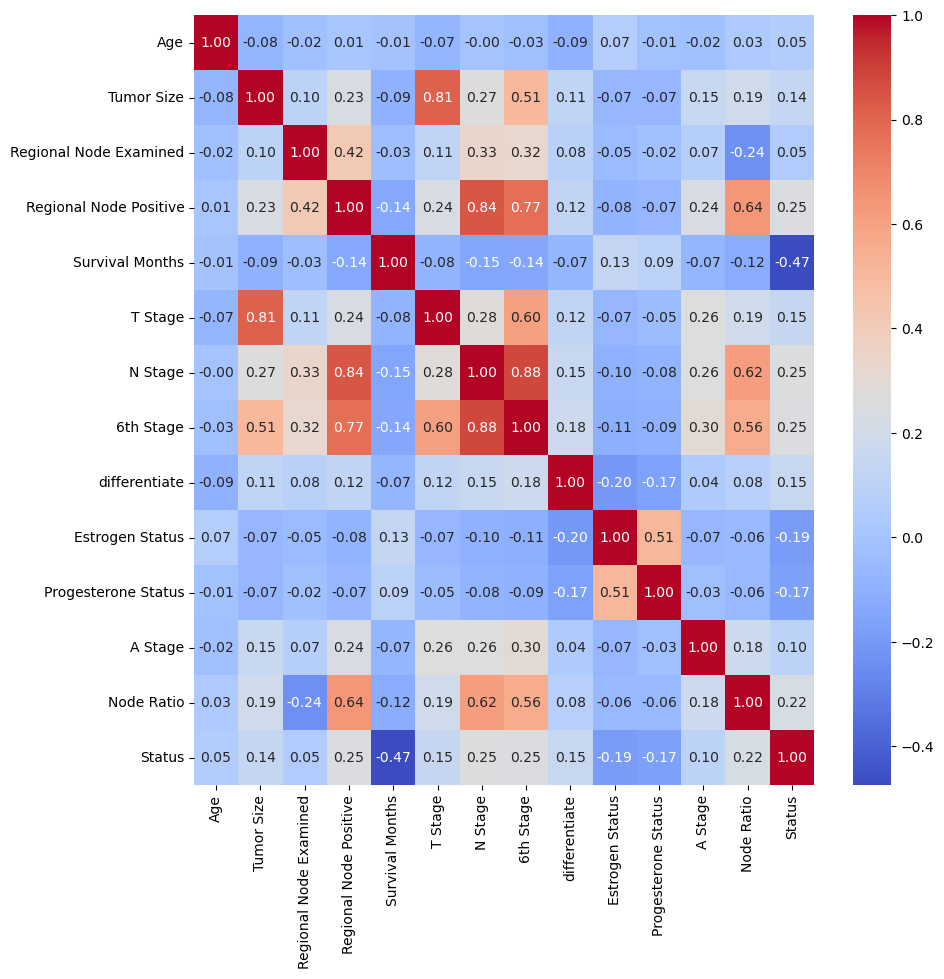

In [6]:
# List of numerical columns
num_cols = ['Age', 'Tumor Size', 'Regional Node Examined', 
            'Regional Node Positive', 'Survival Months', 'T Stage', 
            'N Stage', '6th Stage', 'differentiate', 'Estrogen Status', 'Progesterone Status', 'A Stage', 'Node Ratio', 'Status']

# Plot correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(df_train[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')

plot_path = os.path.join(os.pardir, 'plots', 'corr_matrix.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

## Categorical Analysis

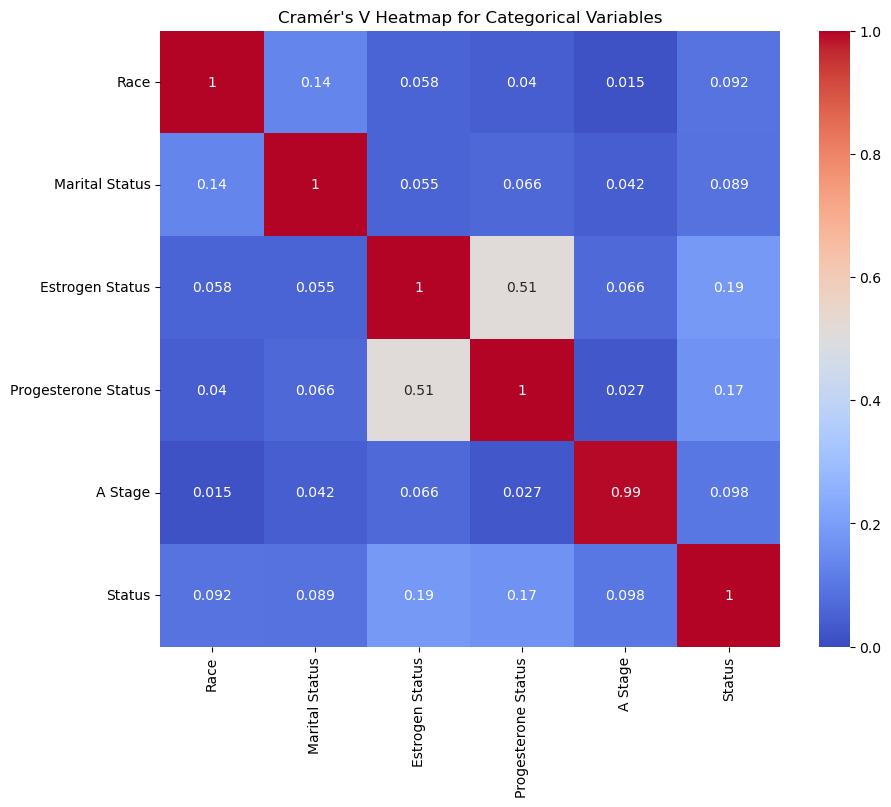

Mutual Information Scores:
Estrogen Status             0.013212
Race_Other                  0.008955
Progesterone Status         0.007202
Marital Status_Separated    0.004133
A Stage                     0.003703
Marital Status_Single       0.002988
Marital Status_Married      0.000387
Race_White                  0.000000
Marital Status_Widowed      0.000000
dtype: float64


In [7]:
# Cramér's V calculation
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(k-1, r-1))))

categorical_features = ['Race', 'Marital Status', 'Estrogen Status', 'Progesterone Status', 'A Stage', 'Status']

cramers_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features, dtype=float)

for var1 in categorical_features:
    for var2 in categorical_features:
        cramers_matrix.loc[var1, var2] = cramers_v(df_train[var1], df_train[var2])

# Heatmap of Cramér's V
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Cramér's V Heatmap for Categorical Variables")
plot_path = os.path.join(os.pardir, 'plots', 'cramerV_matrix.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

np.random.seed(14)
# Mutual Information calculation
df_cat = df_breast_cancer[categorical_features].drop(columns=['Status'])
df_cat_encoded = pd.get_dummies(df_cat, drop_first=True)  # One-hot encode non-binary variables
mi_scores = mutual_info_classif(df_cat_encoded, df_breast_cancer['Status'])
mi_scores = pd.Series(mi_scores, index=df_cat_encoded.columns)
print("Mutual Information Scores:")
print(mi_scores.sort_values(ascending=False))

In [8]:
X_train = X_train.drop(columns=['Race', 'Marital Status'])
X_test = X_test.drop(columns=['Race', 'Marital Status'])

## With Oversampled Data

### PCA

In [9]:
# Scale
X_train_pca = X_train_oversampled.drop(columns=['Estrogen Status', 'Progesterone Status', 'A Stage'])
X_test_pca = X_test.drop(columns=['Estrogen Status', 'Progesterone Status', 'A Stage'])

# Define outlier and non-outlier columns
outlier_columns = ['Tumor Size', 'Regional Node Examined', 'Regional Node Positive'] 
non_outlier_columns = [col for col in X_train_pca.columns if col not in outlier_columns]

# Create a column transformer
scaler = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), non_outlier_columns),
        ('robust', RobustScaler(), outlier_columns)
    ]
)

# Fit and transform the data
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)

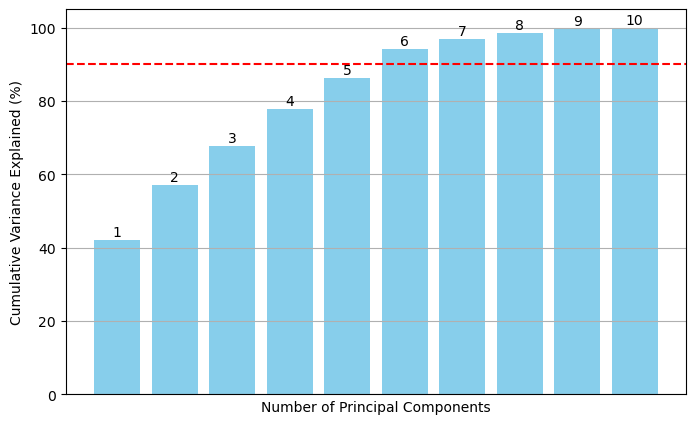

In [10]:
pca = PCA()
pca_result_train = pca.fit_transform(X_train_pca_scaled)
pca_result_test = pca.transform(X_test_pca_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_ * 100)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(cumulative_variance) + 1), cumulative_variance, color='skyblue')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained (%)')
# plt.title('Scree Plot: Cumulative Variance Explained by Principal Components')
plt.grid(axis='y')
plt.xticks([])
plt.axhline(y=90, color='r', linestyle='--')
for i, var in enumerate(cumulative_variance):
    plt.text(i + 1, var + 1, str(i + 1), ha='center')
# plot_path = os.path.join(os.pardir, 'plots', 'cum_var.png')
# plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

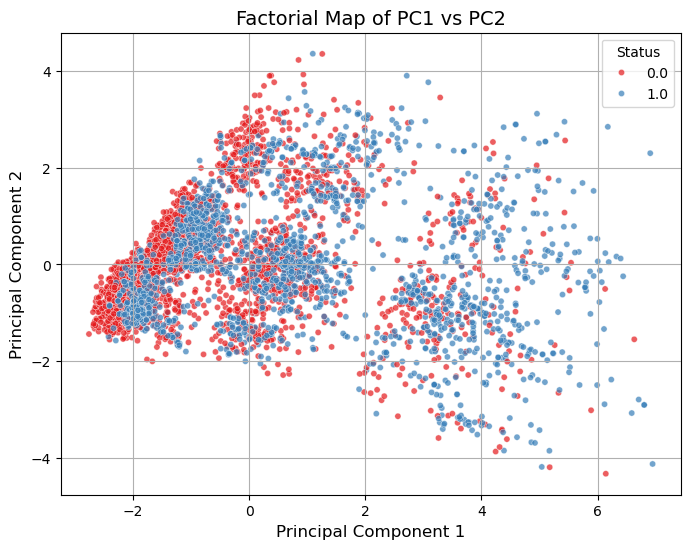

In [12]:
pca_df = pd.DataFrame(pca_result_train, columns=[f'PC{i+1}' for i in range(pca_result_train.shape[1])])
pca_df_test = pd.DataFrame(pca_result_test, columns=[f'PC{i+1}' for i in range(pca_result_test.shape[1])])

# Plot the factorial map (PC1 vs PC2) with 'Status' as the hue
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue=y_train_oversampled, data=pca_df, palette='Set1', s=20, alpha=0.7)
plt.title('Factorial Map of PC1 vs PC2', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Status')
plt.grid(True)
# plot_path = os.path.join(os.pardir, 'plots', 'fact_scatterplot.png')
# plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

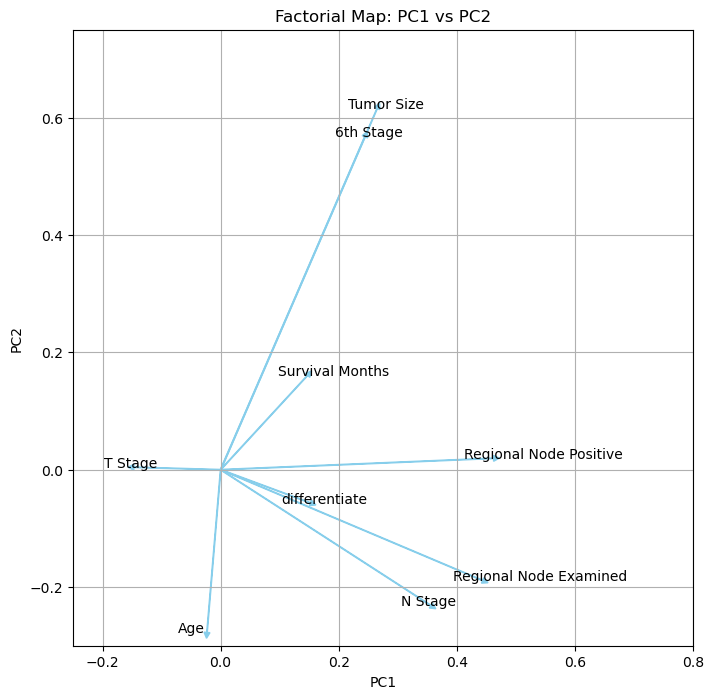

In [13]:
# Plot factorial map with variable arrows for a given PC
def plot_factorial_map_with_arrows(pc1_index, pc2_index):
  plt.figure(figsize=(8, 8))

  for i, var in enumerate(['Age', 'Tumor Size', 'Regional Node Examined','Regional Node Positive', 'Survival Months', 'T Stage','N Stage', '6th Stage', 'differentiate']):
    plt.arrow(0, 0, pca.components_[pc1_index, i], pca.components_[pc2_index, i],
              head_width=0.01, head_length=0.01, color='skyblue')
    plt.text(pca.components_[pc1_index, i] - 0.05, pca.components_[pc2_index, i], var, fontsize=10, color='black', ha='left')

  plt.xlim(-0.25, 0.8)
  plt.ylim(-0.3, 0.75)

  plt.xlabel(f'PC{pc1_index + 1}')
  plt.ylabel(f'PC{pc2_index + 1}')
  plt.title(f'Factorial Map: PC{pc1_index + 1} vs PC{pc2_index + 1}')
  plt.grid(True)
  plt.show()

plot_factorial_map_with_arrows(0, 1)  # PC1 vs PC2
# plot_factorial_map_with_arrows(0, 2)  # PC1 vs PC3
# plot_factorial_map_with_arrows(1, 2)  # PC2 vs PC3

### Recursive Feature Elimination

In [14]:
binary_columns = X_train_oversampled[['Survival Months', 'Node Ratio','Estrogen Status', 'Progesterone Status', 'A Stage']]
X_train_pca = pd.concat([pca_df, binary_columns.reset_index(drop=True)], axis=1)

binary_columns = X_test[['Survival Months', 'Node Ratio','Estrogen Status', 'Progesterone Status', 'A Stage']]
X_test_pca = pd.concat([pca_df_test, binary_columns.reset_index(drop=True)], axis=1)

Best OOB score: 0.8860595597755718
Best features: ['PC1', 'PC3', 'PC4', 'PC5', 'PC6', 'PC8', 'PC9', 'PC10', 'Survival Months', 'Node Ratio']


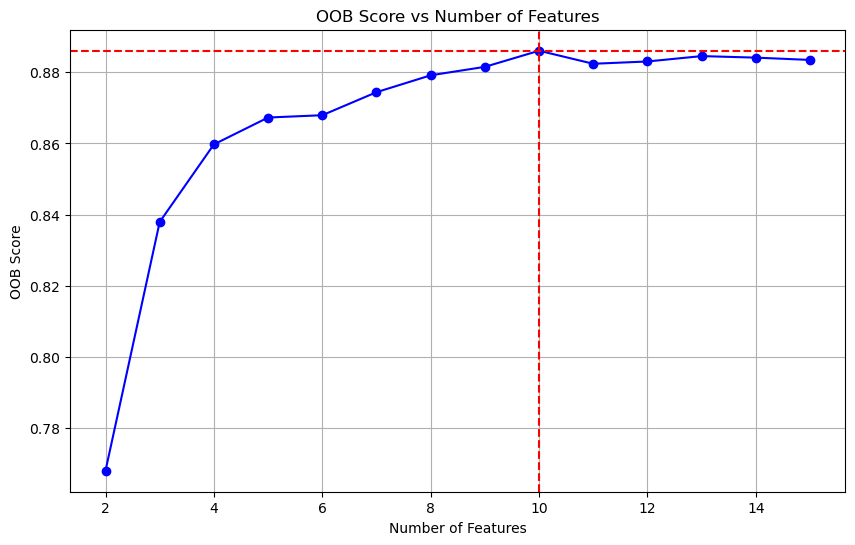

In [16]:
def custom_metric(y_true, y_pred):
    return recall_score(y_true, y_pred, average='weighted')

rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    max_samples = 0.7, 
    oob_score=custom_metric,
    criterion='entropy',
    class_weight='balanced_subsample', 
    random_state=14
)

oob_scores = []
num_features = []
best_oob_score = 0
features = X_train_pca.columns.tolist()

# Recursive Feature Elimination
while len(features) > 1:
    rf_classifier.fit(X_train_pca[features], y_train_oversampled)

    if best_oob_score <= rf_classifier.oob_score_ + 0.001:
        best_oob_score = rf_classifier.oob_score_
        best_features = features.copy()
    
    oob_scores.append(rf_classifier.oob_score_)
    num_features.append(len(features))

    # Get features importances, and remove least important feature
    feature_importances = rf_classifier.feature_importances_
    least_important_feature = features[feature_importances.argmin()]

    features.remove(least_important_feature)

print(f'Best OOB score: {best_oob_score}')
print(f'Best features: {best_features}')

# Plot OOB score against the number of features
plt.figure(figsize=(10, 6))
plt.plot(num_features, oob_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Features')
plt.ylabel('OOB Score')
plt.title('OOB Score vs Number of Features')
plt.axhline(y=best_oob_score, color='r', linestyle='--')
plt.axvline(x=len(best_features), color='r', linestyle='--')
plt.grid(True)
plot_path = os.path.join(os.pardir, 'plots', 'RFE_oversampled.png')
plt.savefig(plot_path)
plt.show()

X_train_oversampled_best = X_train_pca[best_features]
X_test_oversampled_best = X_test_pca[best_features]

## With Original Dataset

### PCA

In [17]:
# Scale
X_train_pca = X_train.drop(columns=['Estrogen Status', 'Progesterone Status', 'A Stage'])
X_test_pca = X_test.drop(columns=['Estrogen Status', 'Progesterone Status', 'A Stage'])

# Define outlier and non-outlier columns
outlier_columns = ['Tumor Size', 'Regional Node Examined', 'Regional Node Positive'] 
non_outlier_columns = [col for col in X_train_pca.columns if col not in outlier_columns]

# Create a column transformer
scaler = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), non_outlier_columns),
        ('robust', RobustScaler(), outlier_columns)
    ]
)

# Fit and transform the data
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)

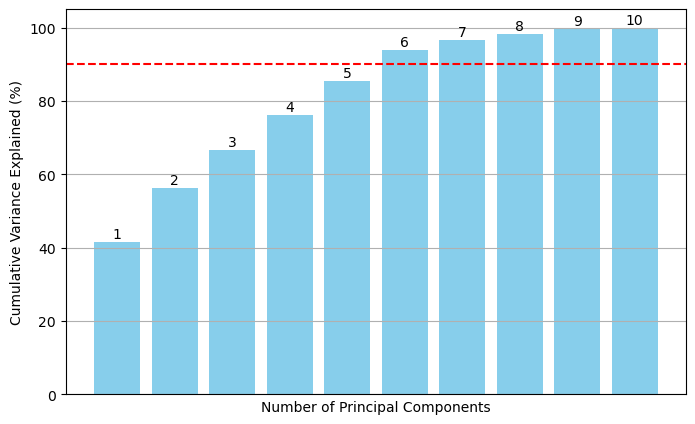

In [18]:
pca = PCA()
pca_result_train = pca.fit_transform(X_train_pca_scaled)
pca_result_test = pca.transform(X_test_pca_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_ * 100)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(cumulative_variance) + 1), cumulative_variance, color='skyblue')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained (%)')
# plt.title('Scree Plot: Cumulative Variance Explained by Principal Components')
plt.grid(axis='y')
plt.xticks([])
plt.axhline(y=90, color='r', linestyle='--')
for i, var in enumerate(cumulative_variance):
    plt.text(i + 1, var + 1, str(i + 1), ha='center')
plot_path = os.path.join(os.pardir, 'plots', 'cum_var.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

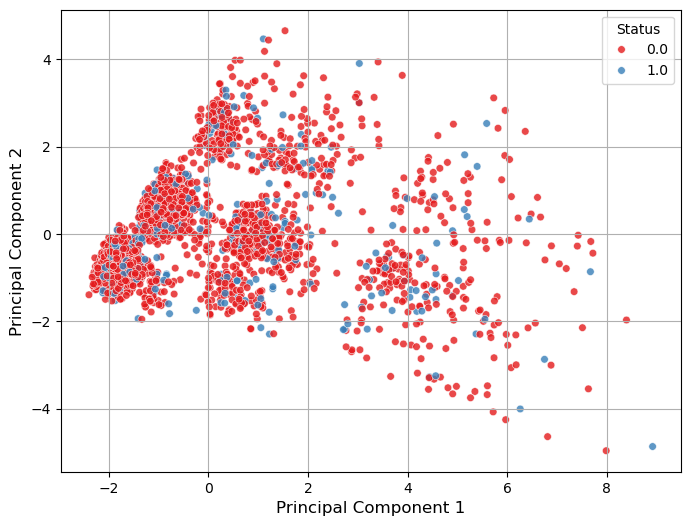

In [19]:
pca_df = pd.DataFrame(pca_result_train, columns=[f'PC{i+1}' for i in range(pca_result_train.shape[1])])
pca_df_test = pd.DataFrame(pca_result_test, columns=[f'PC{i+1}' for i in range(pca_result_test.shape[1])])

# Plot the factorial map (PC1 vs PC2) with 'Status' as the hue
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue=y_train, data=pca_df, palette='Set1', s=30, alpha=0.8)
plt.title('', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Status')
plt.grid(True)
plot_path = os.path.join(os.pardir, 'plots', 'fact_scatterplot.png')
plt.savefig(plot_path)
plt.show()

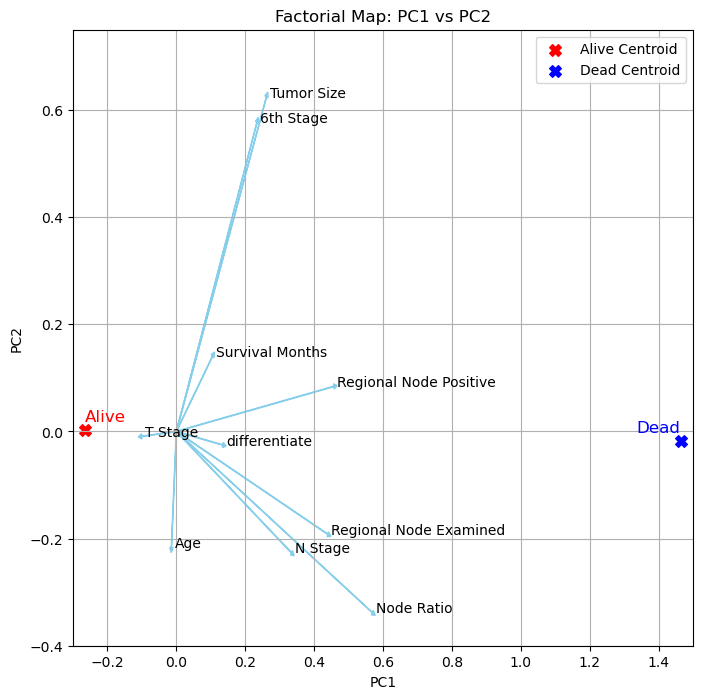

In [ ]:
# Plot factorial map with variable arrows and class centroids
def plot_factorial_map_with_arrows_and_centroids(pc1_index, pc2_index):
    plt.figure(figsize=(8, 8))

    # Plot feature arrows
    for i, var in enumerate(['Age', 'Tumor Size', 'Regional Node Examined', 'Regional Node Positive', 'Survival Months', 'T Stage', 'N Stage', '6th Stage', 'differentiate', 'Node Ratio']):
        plt.arrow(0, 0, pca.components_[pc1_index, i], pca.components_[pc2_index, i],
                  head_width=0.01, head_length=0.01, color='skyblue')
        plt.text(pca.components_[pc1_index, i] + 0.01, pca.components_[pc2_index, i], var, fontsize=10, color='black', ha='left')

    # Calculate centroids for classes 0 and 1
    class_0_indices = np.where(y_train == 0)[0]
    class_1_indices = np.where(y_train == 1)[0]
    class_0_centroid = np.mean(pca_result_train[class_0_indices, :], axis=0)
    class_1_centroid = np.mean(pca_result_train[class_1_indices, :], axis=0)

    # Plot centroids
    plt.scatter(class_0_centroid[pc1_index], class_0_centroid[pc2_index], color='red', label='Alive Centroid', s=70, marker='X')
    plt.scatter(class_1_centroid[pc1_index], class_1_centroid[pc2_index], color='blue', label='Dead Centroid', s=70, marker='X')

    plt.text(class_0_centroid[pc1_index], class_0_centroid[pc2_index] + 0.015, 'Alive', fontsize=12, color='red', ha='left')
    plt.text(class_1_centroid[pc1_index], class_1_centroid[pc2_index] + 0.015, 'Dead', fontsize=12, color='blue', ha='right')

    plt.xlim(-0.3, 1.5)
    plt.ylim(-0.4, 0.75)

    plt.xlabel(f'PC{pc1_index + 1}')
    plt.ylabel(f'PC{pc2_index + 1}')
    plt.title(f'Factorial Map: PC{pc1_index + 1} vs PC{pc2_index + 1}')
    plt.grid(True)
    plt.legend()
    plot_path = os.path.join(os.pardir, 'plots', 'fact_map_with_centroids.png')
    plt.savefig(plot_path)
    plt.show()

plot_factorial_map_with_arrows_and_centroids(0, 1)


### RFE

In [21]:
binary_columns = X_train[['Survival Months', 'Node Ratio', 'Estrogen Status', 'Progesterone Status', 'A Stage']]
X_train_pca = pd.concat([pca_df, binary_columns.reset_index(drop=True)], axis=1)

binary_columns = X_test[['Survival Months', 'Node Ratio', 'Estrogen Status', 'Progesterone Status', 'A Stage']]
X_test_pca = pd.concat([pca_df_test, binary_columns.reset_index(drop=True)], axis=1)

Weights: 
[[0.         0.59042553]
 [1.         3.26470588]]

Best OOB score: 0.8981050015532774
Best features: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'Survival Months', 'Node Ratio', 'Estrogen Status', 'Progesterone Status']


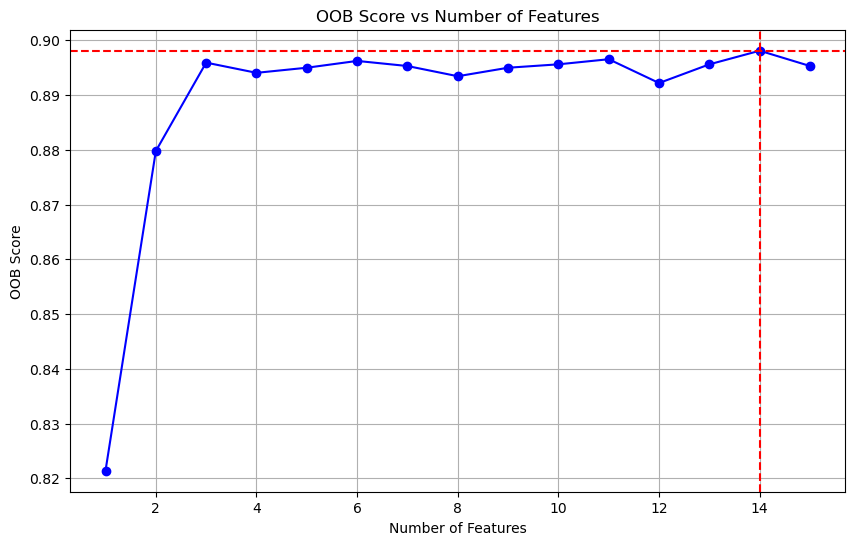

In [22]:
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train) # Compute weights based on the class frequency (less frequent -> higher weights)
# Get the weights assigned to each class
y_train_weights = np.column_stack((y_train, sample_weights))
quality_weights = np.unique(y_train_weights, axis=0)
print(f'Weights: \n{quality_weights}\n')

# Define a custom metric
def custom_metric(y_true, y_pred):
    return recall_score(y_true, y_pred, average='weighted')

rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    max_samples = 0.7, 
    oob_score=custom_metric, 
    criterion='entropy',
    class_weight='balanced_subsample',
    random_state=14
)

oob_scores = []
num_features = []
best_oob_score = 0
features = X_train_pca.columns.tolist()

# Recursive Feature Elimination
while len(features) >= 1:
    rf_classifier.fit(X_train_pca[features], y_train, sample_weight=sample_weights)

    if best_oob_score <= rf_classifier.oob_score_ + 0.001:
        best_oob_score = rf_classifier.oob_score_
        best_features = features.copy()
    
    oob_scores.append(rf_classifier.oob_score_)
    num_features.append(len(features))

    # Get features importances, and remove least important feature
    feature_importances = rf_classifier.feature_importances_
    least_important_feature = features[feature_importances.argmin()]

    features.remove(least_important_feature)

print(f'Best OOB score: {best_oob_score}')
print(f'Best features: {best_features}')

# Plot OOB score against the number of features
plt.figure(figsize=(10, 6))
plt.plot(num_features, oob_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Features')
plt.ylabel('OOB Score')
plt.title('OOB Score vs Number of Features')
plt.axhline(y=best_oob_score, color='r', linestyle='--')
plt.axvline(x=len(best_features), color='r', linestyle='--')
plt.grid(True)
plot_path = os.path.join(os.pardir, 'plots', 'RFE.png')
plt.savefig(plot_path)
plt.show()

X_train_original_best = X_train_pca[best_features]
X_test_original_best = X_test_pca[best_features]

# Modeling

## With Oversampled Dataset

### Random Forest Classifier

In [23]:
# Define a custom metric
def custom_metric(y_true, y_pred):
    return recall_score(y_true, y_pred, average='weighted')

# Define a function to perform the grid search for hyperparameter tuning
def tune_random_forest(X_train_best, y_train, n_estimators_list, max_samples_list, max_features_list):
    best_f1_score = 0
    best_params = {}
    np.random.seed(42)
    for n_estimators in n_estimators_list:
        for max_samples in max_samples_list:
            for max_features in max_features_list:
                for max_depth in max_depth_list:
                    rf_classifier = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_samples=max_samples,
                        max_features=max_features,
                        max_depth=max_depth,
                        criterion='entropy',
                        class_weight='balanced_subsample',
                        random_state=42,
                        oob_score=custom_metric
                    )

                    # Fit the model
                    rf_classifier.fit(X_train_best, y_train)
                    oob_score = rf_classifier.oob_score_
                    
                    # Update the best parameters based on F1-weighted score
                    if oob_score > best_f1_score:
                        best_f1_score = oob_score
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_samples': max_samples,
                            'max_features': max_features,
                            'max_depth': max_depth,
                        }

    return best_params, best_f1_score

# Hyperparameters ranges to search
n_estimators_list = [100, 150]
max_samples_list = [0.6, 0.7, 0.8]
max_features_list = ['sqrt', 'log2', None]
max_depth_list = [10, None]

# Tune hyperparameters
best_params, best_recall_score = tune_random_forest(X_train_oversampled_best, y_train_oversampled, n_estimators_list, max_samples_list, max_features_list)

print(f"Best parameters: {best_params}")
print(f"Best F1-weighted score: {best_recall_score}")

Best parameters: {'n_estimators': 150, 'max_samples': 0.8, 'max_features': 'sqrt', 'max_depth': None}
Best F1-weighted score: 0.8903754855416487


In [24]:
# Train the final model with the best parameters
rf_classifier = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_samples=best_params['max_samples'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    random_state=42
)

rf_classifier.fit(X_train_oversampled_best, y_train_oversampled)

y_pred = rf_classifier.predict(X_test_oversampled_best)

reverse_price_mapping = {0: 'Alive', 1: 'Dead'}

# Map the predictions and actual values using the reverse mapping
y_pred_dec = pd.Series(y_pred).map(reverse_price_mapping)
y_test_dec = pd.Series(y_test).map(reverse_price_mapping)

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test_dec, y_pred_dec))

Classification Report:
              precision    recall  f1-score   support

       Alive       0.93      0.91      0.92       682
        Dead       0.56      0.62      0.59       123

    accuracy                           0.87       805
   macro avg       0.75      0.77      0.76       805
weighted avg       0.87      0.87      0.87       805



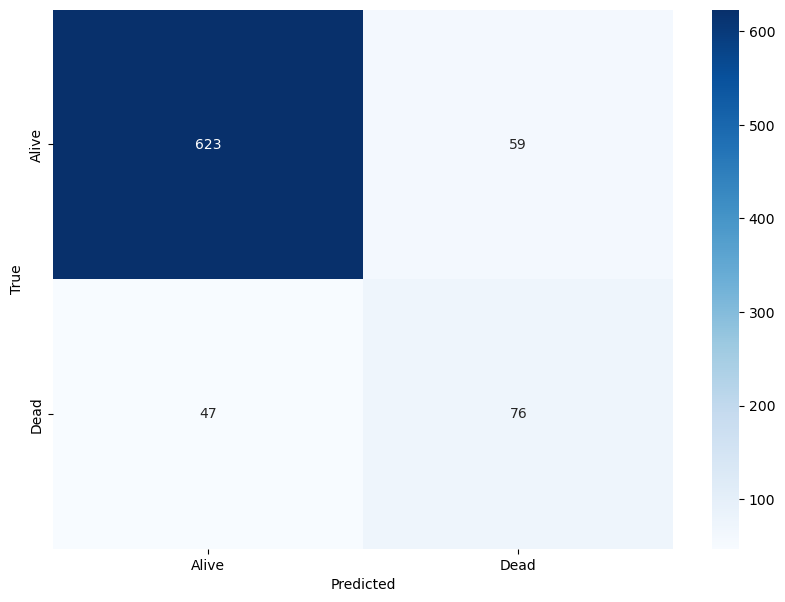

In [25]:
classes = y_test_dec.unique()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_dec, y_pred_dec, labels=classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## With Original Dataset

### Random Forest Classifier

In [26]:
# Define a function to perform the grid search for hyperparameter tuning
def tune_random_forest(X_train_best, y_train, n_estimators_list, max_samples_list, max_features_list):
    best_recall_score = 0
    best_params = {}
    np.random.seed(42)
    for n_estimators in n_estimators_list:
        for max_samples in max_samples_list:
            for max_features in max_features_list:
                for max_depth in max_depth_list:
                    rf_classifier = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_samples=max_samples,
                        max_features=max_features,
                        max_depth=max_depth,
                        criterion='entropy',
                        class_weight='balanced_subsample',
                        random_state=42,
                        oob_score=custom_metric
                    )

                    # Fit the model
                    rf_classifier.fit(X_train_best, y_train, sample_weight=sample_weights)
                    oob_score = rf_classifier.oob_score_
                    
                    # Update the best parameters based on F1-weighted score
                    if oob_score > best_recall_score:
                        best_recall_score = oob_score
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_samples': max_samples,
                            'max_features': max_features,
                            'max_depth': max_depth,
                        }

    return best_params, best_recall_score

# Hyperparameters ranges to search
n_estimators_list = [100, 150, 200]
max_samples_list = [0.6, 0.7, 0.8]
max_depth_list = [10, None]
max_features_list = ['sqrt', 'log2', None]

best_params, best_f1_score = tune_random_forest(X_train_original_best, y_train, n_estimators_list, max_samples_list, max_features_list)

print(f"Best parameters: {best_params}")
print(f"Best Recall-weighted score: {best_f1_score}")

Best parameters: {'n_estimators': 100, 'max_samples': 0.7, 'max_features': None, 'max_depth': None}
Best Recall-weighted score: 0.9012115563839702


In [27]:
# Train the final model with the best parameters
rf_classifier = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_samples=best_params['max_samples'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    criterion='entropy',
    class_weight='balanced_subsample',
    random_state=42
)

rf_classifier.fit(X_train_original_best, y_train, sample_weight=sample_weights)

y_pred = rf_classifier.predict(X_test_original_best)

reverse_price_mapping = {0: 'Alive', 1: 'Dead'}

# Map the predictions and actual values using the reverse mapping
y_pred_dec = pd.Series(y_pred).map(reverse_price_mapping)
y_test_dec = pd.Series(y_test).map(reverse_price_mapping)

print("Classification Report:")
print(classification_report(y_test_dec, y_pred_dec))

Classification Report:
              precision    recall  f1-score   support

       Alive       0.93      0.97      0.95       682
        Dead       0.78      0.58      0.66       123

    accuracy                           0.91       805
   macro avg       0.85      0.77      0.81       805
weighted avg       0.90      0.91      0.90       805



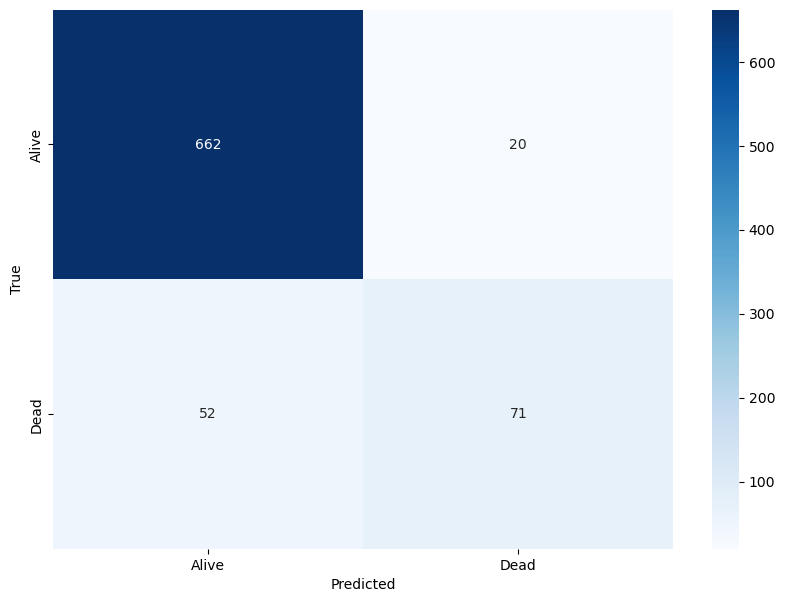

In [28]:
classes = y_test_dec.unique()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_dec, y_pred_dec, labels=classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.savefig('/content/drive/MyDrive/ML_Project/conf_matrix.png')
plt.show()